In [1]:
import csv
import datetime
import glob

import pickle
import scipy.sparse
import time
import zipfile 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter

sns.set_style('whitegrid')
sns.set_palette('pastel')
sns.set_context('poster')

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
print(torch.cuda.device_count())

0


In [3]:
with open('data/refit_data_by_category.pk', 'rb') as f:
    data = pickle.load(f)
    
train, test = data['train'], data['test']

# **DSC & VSC (regular & transfer)**

### Define models

In [4]:
def rbf_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y) ** 2)

def MMD(X, Y, gamma=1e-5):
    if len(X.shape) == 1:
        X = X[:, np.newaxis]
    if len(Y.shape) == 1:
        Y = Y[:, np.newaxis]
    m = X.shape[0]
    n = Y.shape[0]
    
    source_kernel_value = 1
    target_kernel_value = 1
    if m != 1:
        source_kernel_value =  sum(rbf_kernel(X[i], X[j], gamma) for i in range(m) for j in range(m) if i != j) / (m * (m - 1))
    if n != 1:
        target_kernel_value =  sum(rbf_kernel(X[i], X[j], gamma) for i in range(m) for j in range(m) if i != j) / (m * (m - 1))
    s_t_value = 2 * sum(rbf_kernel(X[i], Y[j], gamma) for i in range(m) for j in range(n)) / (m * n)

    return  np.sqrt(np.abs(source_kernel_value + target_kernel_value - s_t_value))


In [5]:
class DSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False, target_ind=None):
        super(DSC, self).__init__()
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step # for now
        self.target_ind = target_ind # activates mmd directly
        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )
        #self.classifier = nn.Linear(encoding_dim, output_size)

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False
        
    def forward(self, x):
        z = self.encoder(x)
        a = z#torch.sign(z) * torch.relu(torch.abs(z) - 0.2)   # <--------- here is where the sparsity penalty occurs. The threshold is 0.01
        y_hat = self.decoder(a)
        #x_hat
        #y_hat = self.classifier(a.mean(dim=2))
        return y_hat, a, self.encoder[0].weight
    
    def loss(self, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        sparsity_loss = 0.2 * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = sparsity_loss + negativity_loss
        mmd_loss = 0
        if self.target_ind is not None:
            mmd_loss = 1e4*MMD(
                X = enc[:self.target_ind,:,:].squeeze(0).detach().numpy(),
                Y = enc[self.target_ind:,:,:].squeeze(0).detach().numpy(),
            )
        return loss + mmd_loss

In [6]:
class DeepSC(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, code_dim, sparsity_penalty, enable_transfer_learning=False, DD_step=False):
        super(DeepSC, self).__init__()
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step # for now

        self.sparsity_penalty = sparsity_penalty

        self.encoder = nn.Sequential(
            nn.Conv1d(input_dim, hidden_dim1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim1, code_dim, kernel_size=3, padding=1)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(code_dim, hidden_dim1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim1, input_dim, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        # Encoding
        enc = self.encoder(x)
        # Decoding
        dec = self.decoder(enc)
        return enc, dec
    
    def loss(self, x, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        #criterion = nn.MSELoss()
        #reconstruction_loss = criterion(dec, y)
        sparsity_loss = self.sparsity_penalty * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = reconstruction_loss + sparsity_loss + negativity_loss
        return x, loss, reconstruction_loss, sparsity_loss, negativity_loss


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VSC(nn.Module):
    def __init__(self, input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, DD_step=False):#, beta):
        super(VSC, self).__init__()
        
        self.num_filters = num_filters
        self.encoding_dim = encoding_dim
        self.enable_transfer_learning = enable_transfer_learning
        self.DD_step = DD_step
        #self.beta = beta

        self.encoder = nn.Sequential(
            nn.Conv1d(1, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, filter_size, padding=filter_size//2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(num_filters, num_filters, filter_size, padding=filter_size//2),
            nn.ReLU(),
            nn.ConvTranspose1d(num_filters, 1, filter_size, padding=filter_size//2),
            nn.LeakyReLU(),
        )

        if self.DD_step:
            for param in self.encoder[:2].parameters():
                param.requires_grad = False

        if self.enable_transfer_learning:
            for param in self.encoder[:1].parameters():
                param.requires_grad = False

    def forward(self, x):
        z = self.encoder(x)
        mean = z.mean(dim=2)
        log_var = z.var(dim=2).log()
        
        # Sample from a spike and slab?*
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(z)  # not like std, more like z
        z = eps * std.unsqueeze(-1).repeat(1, 1, 170) + mean.unsqueeze(-1).repeat(1, 1, 170)

        # sparsify
        a = torch.sign(z) * F.relu(torch.abs(z) - 0.2)
        #a = a.unsqueeze(-1).repeat(1, 1, 171) # instead of repeat, smaple and create the 3rd dimension
        #print(a.shape, z.shape)
        y_hat = self.decoder(a)
        #kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
        return y_hat, a, mean, log_var#, kl_loss

    def loss(self, enc, dec, y):
        reconstruction_loss = torch.norm(dec - y, 'fro')
        sparsity_loss = 0.2 * torch.norm(enc, 1)
        negativity_loss = 0.1 * torch.mean(torch.clamp(-enc, min=0.0) ** 2)
        loss = sparsity_loss + negativity_loss
        return loss

### Define training functions

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
def train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False, enable_mmd=False):
    # split data
    if enable_transfer_learning:
        X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
        y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
    elif use_only_target_for_everything:
        X = train[week]['X_bar'].T.values[8:,:]
        y_cat = train[week]['X'][cat].T.values[8:,:]
    else:
        X = train[week]['X_bar'].T.values
        y_cat = train[week]['X'][cat].T.values

    # 1) Deep Sparse Coding step, input and output are the same
    target_ind_for_model = target_ind if enable_mmd is True else None
    model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=False, target_ind=target_ind_for_model)
    model.to(device)
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print('----> Training for', cat)
    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
        optimizer.zero_grad()

        y_hat, a, encoder = model(inputs)
        #print('a_matrix is {} % sparse'.format(round(100*len(np.where(a.cpu() < 0.1)[0])/(13*25*170), 3)))
        #print('shapes',y_hat.shape, targets.shape)
        #loss = criterion(y_hat, targets)
        loss = model.loss(a, y_hat, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

    weights = (model.encoder[0].weight, model.encoder[2].weight)

    ################################################################################################################################################

    #2) transfer learning
    if enable_transfer_learning:
        # model, loss and optimizer
        transfer_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
        transfer_model.to(device)
        transfer_criterion = nn.MSELoss()
        transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.001)

        print('----> Transfer training for {}'.format(cat))

        for epoch in range(num_epochs):
            running_loss = 0.0
            inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
            transfer_optimizer.zero_grad()

            transfer_model.encoder[0].weight = weights[0]
            transfer_model.encoder[2].weight = weights[1]
            #transfer_model.encoder[4].weight = model.encoder[4].weight

            y_hat, a, encoder = transfer_model(inputs)
            # Compute loss and backpropagate
            #loss = transfer_criterion(y_hat, targets)
            loss = transfer_model.loss(a, y_hat, targets)
            loss.backward()
            transfer_optimizer.step()

            running_loss += loss.item()

            # Print average loss for epoch (every n epochs)
            if epoch % display_every_n_epochs == 0:
                print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

        weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)

    ################################################################################################################################################

    #3) DD step, we freeze the encoder and take the sparse code and dictionary of the Deep Sparse Coding step
    # model, loss and optimizer
    dd_model = DSC(input_size, output_size, num_filters, filter_size, encoding_dim, DD_step=True, target_ind=target_ind_for_model)
    dd_model.to(device)
    dd_criterion = nn.MSELoss()
    dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

    print('----> DD step for {}'.format(cat))

    X_dd = X
    y_dd = y_cat
    if enable_transfer_learning:
        X_dd = X_t
        y_dd = y_cat_t

    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
        dd_optimizer.zero_grad()

        dd_model.encoder[0].weight = weights[0]
        dd_model.encoder[2].weight = weights[1]
        #dd_model.encoder[4].weight = model.encoder[4].weight

        y_hat, a, encoder = dd_model(inputs)
        # Compute loss and backpropagate
        #loss = dd_criterion(y_hat, targets)
        loss = dd_model.loss(a, y_hat, targets)
        loss.backward()
        dd_optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))

    current_y_cat = y_hat.cpu().detach().numpy().T
    #if enable_transfer_learning:
    #  current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
    #else:
    current_y_test_cat = dd_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

    return current_y_cat, current_y_test_cat


In [10]:
def VSC_train_on_week_and_category(week, cat, learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=None, use_only_target_for_everything=False, num_epochs_vsc_transfer=None):
  # split data
    if enable_transfer_learning:
        X, X_t = train[week]['X_bar'].T.values[:8,:], train[week]['X_bar'].T.values[8:,:]
        y_cat, y_cat_t = train[week]['X'][cat].T.values[:8,:], train[week]['X'][cat].T.values[8:,:]
    elif use_only_target_for_everything:
        X = train[week]['X_bar'].T.values[8:,:]
        y_cat = train[week]['X'][cat].T.values[8:,:]
    else:
        X = train[week]['X_bar'].T.values
        y_cat = train[week]['X'][cat].T.values


  # 1) Variational Sparse Coding step, input and output are the same
    model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim)#, beta)
    model.to(device)
    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print('----> Training for', cat)
    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(y_cat).unsqueeze(1).to(device), torch.Tensor(y_cat).unsqueeze(1).to(device)
        optimizer.zero_grad()

        y_hat, a, mean, logvar = model(inputs)

        #loss = criterion(y_hat, targets) # Reconstruction Loss, no KL divergence since this is a regression problem
        loss = model.loss(a, y_hat, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X)))

    weights = (model.encoder[0].weight, model.encoder[2].weight)

################################################################################################################################################

#2) transfer learning
    if enable_transfer_learning:
        # model ,loss and optimizer
        transfer_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True)
        transfer_model.to(device)
        transfer_criterion = nn.MSELoss()
        transfer_optimizer = optim.Adam(transfer_model.parameters(), lr=0.0005)

        print('----> Transfer training for {}'.format(cat))

        for epoch in range(num_epochs_vsc_transfer):
            running_loss = 0.0
            inputs, targets = torch.Tensor(y_cat_t).unsqueeze(1).to(device), torch.Tensor(y_cat_t).unsqueeze(1).to(device)
            transfer_optimizer.zero_grad()

            transfer_model.encoder[0].weight = weights[0]
            transfer_model.encoder[2].weight = weights[1]
            #transfer_model.encoder[4].weight = model.encoder[4].weight

            y_hat, a, mean, logvar = transfer_model(inputs)

            #loss = criterion(y_hat, targets)  # Reconstruction Loss
            loss = transfer_model.loss(a, y_hat, targets)
            #loss = model.loss_function(y_hat, targets, mu, logvar, logspike, train=False)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Print average loss for epoch (every n epochs)
            if epoch % display_every_n_epochs == 0:
                print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_t)))

        weights = (transfer_model.encoder[0].weight, transfer_model.encoder[2].weight)


################################################################################################################################################

#3) DD step, we freeze the encoder and take the sparse code and dictionary of the Deep Sparse Coding step
  # model ,loss and optimizer
    dd_model = VSC(input_size, output_size, num_filters, filter_size, encoding_dim, enable_transfer_learning=True, DD_step=True)
    dd_model.to(device)
    dd_criterion = nn.MSELoss()
    dd_optimizer = optim.Adam(dd_model.parameters(), lr=0.001)

    print('----> DD step for {}'.format(cat))

    X_dd = X
    y_dd = y_cat
    if enable_transfer_learning:
        X_dd = X_t
        y_dd = y_cat_t

    for epoch in range(num_epochs):
        running_loss = 0.0
        inputs, targets = torch.Tensor(X_dd).unsqueeze(1).to(device), torch.Tensor(y_dd).unsqueeze(1).to(device)
        dd_optimizer.zero_grad()

        dd_model.encoder[0].weight = weights[0]
        dd_model.encoder[2].weight = weights[1]
        #dd_model.encoder[4].weight = model.encoder[4].weight

        y_hat, a, mean, logvar = dd_model(inputs)
        # Compute loss and backpropagate
        #loss = dd_criterion(y_hat, targets)
        loss = dd_model.loss(a, y_hat, targets)
        loss.backward()
        dd_optimizer.step()

        running_loss += loss.item()

        # Print average loss for epoch (every n epochs)
        if epoch % display_every_n_epochs == 0:
            print('Epoch %d loss: %.3f' % (epoch, running_loss / len(X_dd)))

    current_y_cat = y_hat.cpu().detach().numpy().T
    if enable_transfer_learning:
        current_y_test_cat = transfer_model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T
    else:
        current_y_test_cat = model.forward(torch.Tensor(test[week]['X'][cat].T.values).unsqueeze(1).to(device))[0].cpu().detach().numpy().T

    return current_y_cat, current_y_test_cat

### Hyperparameters and variables

In [11]:
# Define hyperparameters
input_size = 168
output_size = 168
num_filters = 25
filter_size = 10
encoding_dim = 64
dsc_learning_rate = 0.001
vsc_learning_rate = 0.0005

num_epochs = 401
num_epochs_vsc_transfer = 50
nb_displays = 4
display_every_n_epochs = num_epochs // nb_displays
target_ind = 8

appliance_categories = list(train[0]['X'].keys())
weeks_to_train = len(train) - 1 #*

In [12]:
#weeks_to_train = 2

# **Training blocks**

#### DSC

In [13]:
y_apps = []
y_apps_test = []
#weeks_to_train = 10 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps.append(current_y)
  y_apps_test.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 13611.468
Epoch 100 loss: 1036.577
Epoch 200 loss: 483.147
Epoch 300 loss: 392.230
Epoch 400 loss: 350.414
----> DD step for fridge
Epoch 0 loss: 3034.610
Epoch 100 loss: 2987.286
Epoch 200 loss: 2942.481
Epoch 300 loss: 2901.407
Epoch 400 loss: 2864.513
----> Training for washing_drying
Epoch 0 loss: 28081.010
Epoch 100 loss: 1377.304
Epoch 200 loss: 758.483
Epoch 300 loss: 551.774
Epoch 400 loss: 471.889
----> DD step for washing_drying
Epoch 0 loss: 6822.749
Epoch 100 loss: 6790.428
Epoch 200 loss: 6759.439
Epoch 300 loss: 6729.915
Epoch 400 loss: 6701.641
----> Training for computer_tv
Epoch 0 loss: 9626.128
Epoch 100 loss: 579.859
Epoch 200 loss: 311.859
Epoch 300 loss: 257.862
Epoch 400 loss: 267.134
----> DD step for computer_tv
Epoch 0 loss: 4035.805
Epoch 100 loss: 3994.493
Epoch 200 loss: 3956.615
Epoch 300 loss: 3922.138
Epoch 400 loss: 3890.985
----> Training for heating
Epoch 0 loss: 9531.603
Epoch 100 loss: 525.814
Epoch 200 

Epoch 100 loss: 303.213
Epoch 200 loss: 232.168
Epoch 300 loss: 234.545
Epoch 400 loss: 195.630
----> DD step for heating
Epoch 0 loss: 22380.144
Epoch 100 loss: 22352.760
Epoch 200 loss: 22326.031
Epoch 300 loss: 22299.704
Epoch 400 loss: 22273.942
WEEK 7
----> Training for fridge
Epoch 0 loss: 12969.516
Epoch 100 loss: 1040.372
Epoch 200 loss: 510.228
Epoch 300 loss: 365.756
Epoch 400 loss: 295.886
----> DD step for fridge
Epoch 0 loss: 2722.910
Epoch 100 loss: 2679.542
Epoch 200 loss: 2641.562
Epoch 300 loss: 2609.812
Epoch 400 loss: 2584.217
----> Training for washing_drying
Epoch 0 loss: 25276.481
Epoch 100 loss: 1143.838
Epoch 200 loss: 646.180
Epoch 300 loss: 481.513
Epoch 400 loss: 403.716
----> DD step for washing_drying
Epoch 0 loss: 6815.838
Epoch 100 loss: 6803.635
Epoch 200 loss: 6793.446
Epoch 300 loss: 6784.824
Epoch 400 loss: 6777.321
----> Training for computer_tv
Epoch 0 loss: 9121.361
Epoch 100 loss: 553.526
Epoch 200 loss: 333.474
Epoch 300 loss: 251.522
Epoch 400 l

Epoch 100 loss: 512.640
Epoch 200 loss: 266.308
Epoch 300 loss: 192.001
Epoch 400 loss: 166.598
----> DD step for computer_tv
Epoch 0 loss: 4102.298
Epoch 100 loss: 4081.340
Epoch 200 loss: 4064.339
Epoch 300 loss: 4050.701
Epoch 400 loss: 4040.002
----> Training for heating
Epoch 0 loss: 18259.821
Epoch 100 loss: 895.541
Epoch 200 loss: 530.667
Epoch 300 loss: 329.295
Epoch 400 loss: 314.773
----> DD step for heating
Epoch 0 loss: 3950.902
Epoch 100 loss: 3889.020
Epoch 200 loss: 3830.165
Epoch 300 loss: 3774.041
Epoch 400 loss: 3720.314
WEEK 14
----> Training for fridge
Epoch 0 loss: 13570.886
Epoch 100 loss: 1034.881
Epoch 200 loss: 502.436
Epoch 300 loss: 362.231
Epoch 400 loss: 314.233
----> DD step for fridge
Epoch 0 loss: 3136.078
Epoch 100 loss: 3085.904
Epoch 200 loss: 3038.708
Epoch 300 loss: 2994.046
Epoch 400 loss: 2952.066
----> Training for washing_drying
Epoch 0 loss: 32915.065
Epoch 100 loss: 1928.590
Epoch 200 loss: 878.859
Epoch 300 loss: 622.867
Epoch 400 loss: 469.4

Epoch 100 loss: 2646.798
Epoch 200 loss: 1312.340
Epoch 300 loss: 1065.564
Epoch 400 loss: 895.753
----> DD step for washing_drying
Epoch 0 loss: 8114.629
Epoch 100 loss: 8044.213
Epoch 200 loss: 7974.877
Epoch 300 loss: 7906.772
Epoch 400 loss: 7839.672
----> Training for computer_tv
Epoch 0 loss: 6526.767
Epoch 100 loss: 451.944
Epoch 200 loss: 208.852
Epoch 300 loss: 144.380
Epoch 400 loss: 109.851
----> DD step for computer_tv
Epoch 0 loss: 3713.239
Epoch 100 loss: 3698.870
Epoch 200 loss: 3689.172
Epoch 300 loss: 3683.018
Epoch 400 loss: 3679.110
----> Training for heating
Epoch 0 loss: 12839.928
Epoch 100 loss: 435.104
Epoch 200 loss: 306.459
Epoch 300 loss: 242.563
Epoch 400 loss: 220.550
----> DD step for heating
Epoch 0 loss: 19771.002
Epoch 100 loss: 19746.644
Epoch 200 loss: 19722.928
Epoch 300 loss: 19699.531
Epoch 400 loss: 19676.768
WEEK 21
----> Training for fridge
Epoch 0 loss: 12135.421
Epoch 100 loss: 1034.459
Epoch 200 loss: 521.994
Epoch 300 loss: 360.055
Epoch 400 

Epoch 100 loss: 810.776
Epoch 200 loss: 364.835
Epoch 300 loss: 248.146
Epoch 400 loss: 198.600
----> DD step for fridge
Epoch 0 loss: 2082.374
Epoch 100 loss: 2038.274
Epoch 200 loss: 1999.929
Epoch 300 loss: 1967.780
Epoch 400 loss: 1941.464
----> Training for washing_drying
Epoch 0 loss: 48506.760
Epoch 100 loss: 2393.956
Epoch 200 loss: 1331.109
Epoch 300 loss: 957.062
Epoch 400 loss: 775.084
----> DD step for washing_drying
Epoch 0 loss: 7365.800
Epoch 100 loss: 7327.228
Epoch 200 loss: 7289.689
Epoch 300 loss: 7253.125
Epoch 400 loss: 7217.667
----> Training for computer_tv
Epoch 0 loss: 5050.936
Epoch 100 loss: 332.865
Epoch 200 loss: 146.921
Epoch 300 loss: 97.480
Epoch 400 loss: 76.758
----> DD step for computer_tv
Epoch 0 loss: 2466.180
Epoch 100 loss: 2430.525
Epoch 200 loss: 2401.147
Epoch 300 loss: 2379.076
Epoch 400 loss: 2364.341
----> Training for heating
Epoch 0 loss: 14721.424
Epoch 100 loss: 726.309
Epoch 200 loss: 421.709
Epoch 300 loss: 290.774
Epoch 400 loss: 273.

Epoch 100 loss: 381.635
Epoch 200 loss: 234.351
Epoch 300 loss: 172.599
Epoch 400 loss: 148.588
----> DD step for heating
Epoch 0 loss: 12807.120
Epoch 100 loss: 12783.946
Epoch 200 loss: 12761.624
Epoch 300 loss: 12740.201
Epoch 400 loss: 12719.599
WEEK 34
----> Training for fridge
Epoch 0 loss: 11122.945
Epoch 100 loss: 835.505
Epoch 200 loss: 373.231
Epoch 300 loss: 342.635
Epoch 400 loss: 261.250
----> DD step for fridge
Epoch 0 loss: 3138.899
Epoch 100 loss: 3084.412
Epoch 200 loss: 3032.191
Epoch 300 loss: 2983.453
Epoch 400 loss: 2939.963
----> Training for washing_drying
Epoch 0 loss: 35472.680
Epoch 100 loss: 2073.997
Epoch 200 loss: 1065.778
Epoch 300 loss: 770.905
Epoch 400 loss: 607.080
----> DD step for washing_drying
Epoch 0 loss: 5769.916
Epoch 100 loss: 5740.281
Epoch 200 loss: 5712.277
Epoch 300 loss: 5685.659
Epoch 400 loss: 5660.387
----> Training for computer_tv
Epoch 0 loss: 5783.514
Epoch 100 loss: 426.240
Epoch 200 loss: 206.651
Epoch 300 loss: 134.839
Epoch 400 

#### Transfer DSC

In [14]:
y_apps_tdsc = []
y_apps_test_tdsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
    print('WEEK {}'.format(week))
    current_y = dict()
    current_y_test = dict()
    for cat in appliance_categories:
        current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind)

        current_y[cat] = current_y_cat
        current_y_test[cat] = current_y_test_cat

    y_apps_tdsc.append(current_y)
    y_apps_test_tdsc.append(current_y_test)


WEEK 0
----> Training for fridge
Epoch 0 loss: 17909.254
Epoch 100 loss: 1329.941
Epoch 200 loss: 601.938
Epoch 300 loss: 389.786
Epoch 400 loss: 325.640
----> Transfer training for fridge
Epoch 0 loss: 337.996
Epoch 100 loss: 317.460
Epoch 200 loss: 309.987
Epoch 300 loss: 307.731
Epoch 400 loss: 307.079
----> DD step for fridge
Epoch 0 loss: 3296.682
Epoch 100 loss: 3262.323
Epoch 200 loss: 3232.260
Epoch 300 loss: 3206.505
Epoch 400 loss: 3184.888
----> Training for washing_drying
Epoch 0 loss: 27571.500
Epoch 100 loss: 1405.953
Epoch 200 loss: 787.038
Epoch 300 loss: 604.674
Epoch 400 loss: 494.822
----> Transfer training for washing_drying
Epoch 0 loss: 542.255
Epoch 100 loss: 523.577
Epoch 200 loss: 521.649
Epoch 300 loss: 521.652
Epoch 400 loss: 521.658
----> DD step for washing_drying
Epoch 0 loss: 7839.318
Epoch 100 loss: 7811.890
Epoch 200 loss: 7785.933
Epoch 300 loss: 7761.103
Epoch 400 loss: 7737.174
----> Training for computer_tv
Epoch 0 loss: 7048.735
Epoch 100 loss: 539

Epoch 300 loss: 9605.252
Epoch 400 loss: 9580.452
----> Training for computer_tv
Epoch 0 loss: 8833.228
Epoch 100 loss: 564.133
Epoch 200 loss: 324.131
Epoch 300 loss: 253.983
Epoch 400 loss: 224.100
----> Transfer training for computer_tv
Epoch 0 loss: 245.527
Epoch 100 loss: 238.164
Epoch 200 loss: 237.526
Epoch 300 loss: 237.472
Epoch 400 loss: 237.466
----> DD step for computer_tv
Epoch 0 loss: 6727.300
Epoch 100 loss: 6709.601
Epoch 200 loss: 6694.279
Epoch 300 loss: 6681.186
Epoch 400 loss: 6669.999
----> Training for heating
Epoch 0 loss: 4866.790
Epoch 100 loss: 117.341
Epoch 200 loss: 90.830
Epoch 300 loss: 87.306
Epoch 400 loss: 76.028
----> Transfer training for heating
Epoch 0 loss: 940.382
Epoch 100 loss: 919.450
Epoch 200 loss: 918.354
Epoch 300 loss: 918.353
Epoch 400 loss: 918.337
----> DD step for heating
Epoch 0 loss: 16259.881
Epoch 100 loss: 16247.236
Epoch 200 loss: 16235.323
Epoch 300 loss: 16224.117
Epoch 400 loss: 16213.608
WEEK 5
----> Training for fridge
Epoch

Epoch 300 loss: 10076.542
Epoch 400 loss: 10053.537
WEEK 9
----> Training for fridge
Epoch 0 loss: 16895.158
Epoch 100 loss: 1110.861
Epoch 200 loss: 477.668
Epoch 300 loss: 328.673
Epoch 400 loss: 261.714
----> Transfer training for fridge
Epoch 0 loss: 397.453
Epoch 100 loss: 369.888
Epoch 200 loss: 359.207
Epoch 300 loss: 355.914
Epoch 400 loss: 355.148
----> DD step for fridge
Epoch 0 loss: 3941.659
Epoch 100 loss: 3897.311
Epoch 200 loss: 3857.063
Epoch 300 loss: 3822.954
Epoch 400 loss: 3795.959
----> Training for washing_drying
Epoch 0 loss: 33445.797
Epoch 100 loss: 1637.558
Epoch 200 loss: 874.774
Epoch 300 loss: 632.186
Epoch 400 loss: 505.574
----> Transfer training for washing_drying
Epoch 0 loss: 367.656
Epoch 100 loss: 340.604
Epoch 200 loss: 334.550
Epoch 300 loss: 334.007
Epoch 400 loss: 334.003
----> DD step for washing_drying
Epoch 0 loss: 6562.378
Epoch 100 loss: 6527.020
Epoch 200 loss: 6493.023
Epoch 300 loss: 6460.389
Epoch 400 loss: 6428.960
----> Training for co

Epoch 300 loss: 9346.597
Epoch 400 loss: 9319.793
----> Training for computer_tv
Epoch 0 loss: 6935.797
Epoch 100 loss: 500.969
Epoch 200 loss: 235.473
Epoch 300 loss: 168.895
Epoch 400 loss: 154.579
----> Transfer training for computer_tv
Epoch 0 loss: 142.990
Epoch 100 loss: 134.707
Epoch 200 loss: 134.612
Epoch 300 loss: 134.611
Epoch 400 loss: 134.612
----> DD step for computer_tv
Epoch 0 loss: 4444.141
Epoch 100 loss: 4418.075
Epoch 200 loss: 4398.355
Epoch 300 loss: 4384.639
Epoch 400 loss: 4375.177
----> Training for heating
Epoch 0 loss: 20056.734
Epoch 100 loss: 741.511
Epoch 200 loss: 496.318
Epoch 300 loss: 378.340
Epoch 400 loss: 316.605
----> Transfer training for heating
Epoch 0 loss: 783.581
Epoch 100 loss: 755.224
Epoch 200 loss: 751.258
Epoch 300 loss: 751.131
Epoch 400 loss: 751.047
----> DD step for heating
Epoch 0 loss: 9128.548
Epoch 100 loss: 9101.646
Epoch 200 loss: 9076.184
Epoch 300 loss: 9051.880
Epoch 400 loss: 9028.844
WEEK 14
----> Training for fridge
Epoch

Epoch 100 loss: 16348.753
Epoch 200 loss: 16333.633
Epoch 300 loss: 16319.030
Epoch 400 loss: 16304.794
WEEK 18
----> Training for fridge
Epoch 0 loss: 16949.506
Epoch 100 loss: 1254.130
Epoch 200 loss: 581.293
Epoch 300 loss: 433.659
Epoch 400 loss: 382.866
----> Transfer training for fridge
Epoch 0 loss: 370.312
Epoch 100 loss: 344.849
Epoch 200 loss: 332.563
Epoch 300 loss: 326.636
Epoch 400 loss: 323.625
----> DD step for fridge
Epoch 0 loss: 3931.151
Epoch 100 loss: 3881.957
Epoch 200 loss: 3834.653
Epoch 300 loss: 3789.493
Epoch 400 loss: 3746.500
----> Training for washing_drying
Epoch 0 loss: 37679.281
Epoch 100 loss: 2257.281
Epoch 200 loss: 1180.324
Epoch 300 loss: 851.179
Epoch 400 loss: 697.283
----> Transfer training for washing_drying
Epoch 0 loss: 605.582
Epoch 100 loss: 584.924
Epoch 200 loss: 584.390
Epoch 300 loss: 584.379
Epoch 400 loss: 584.388
----> DD step for washing_drying
Epoch 0 loss: 10669.750
Epoch 100 loss: 10643.878
Epoch 200 loss: 10618.927
Epoch 300 loss

Epoch 400 loss: 995.226
----> DD step for washing_drying
Epoch 0 loss: 9184.565
Epoch 100 loss: 9162.578
Epoch 200 loss: 9141.826
Epoch 300 loss: 9122.266
Epoch 400 loss: 9103.493
----> Training for computer_tv
Epoch 0 loss: 7315.000
Epoch 100 loss: 392.506
Epoch 200 loss: 216.084
Epoch 300 loss: 157.493
Epoch 400 loss: 156.409
----> Transfer training for computer_tv
Epoch 0 loss: 170.959
Epoch 100 loss: 150.894
Epoch 200 loss: 147.784
Epoch 300 loss: 147.450
Epoch 400 loss: 147.401
----> DD step for computer_tv
Epoch 0 loss: 5573.768
Epoch 100 loss: 5532.668
Epoch 200 loss: 5493.790
Epoch 300 loss: 5457.382
Epoch 400 loss: 5423.476
----> Training for heating
Epoch 0 loss: 7419.666
Epoch 100 loss: 348.177
Epoch 200 loss: 204.776
Epoch 300 loss: 166.246
Epoch 400 loss: 136.673
----> Transfer training for heating
Epoch 0 loss: 300.390
Epoch 100 loss: 280.606
Epoch 200 loss: 277.958
Epoch 300 loss: 277.855
Epoch 400 loss: 277.821
----> DD step for heating
Epoch 0 loss: 13224.580
Epoch 100

Epoch 100 loss: 517.944
Epoch 200 loss: 516.499
Epoch 300 loss: 516.492
Epoch 400 loss: 516.495
----> DD step for heating
Epoch 0 loss: 6987.573
Epoch 100 loss: 6942.102
Epoch 200 loss: 6897.886
Epoch 300 loss: 6855.193
Epoch 400 loss: 6813.584
WEEK 27
----> Training for fridge
Epoch 0 loss: 12443.461
Epoch 100 loss: 969.142
Epoch 200 loss: 455.715
Epoch 300 loss: 322.976
Epoch 400 loss: 275.527
----> Transfer training for fridge
Epoch 0 loss: 397.268
Epoch 100 loss: 379.730
Epoch 200 loss: 374.280
Epoch 300 loss: 373.044
Epoch 400 loss: 372.773
----> DD step for fridge
Epoch 0 loss: 4000.005
Epoch 100 loss: 3967.132
Epoch 200 loss: 3937.671
Epoch 300 loss: 3911.772
Epoch 400 loss: 3889.705
----> Training for washing_drying
Epoch 0 loss: 55308.434
Epoch 100 loss: 2829.774
Epoch 200 loss: 1689.576
Epoch 300 loss: 1328.742
Epoch 400 loss: 1082.178
----> Transfer training for washing_drying
Epoch 0 loss: 985.866
Epoch 100 loss: 967.018
Epoch 200 loss: 965.601
Epoch 300 loss: 965.557
Epoch

Epoch 300 loss: 846.146
Epoch 400 loss: 678.302
----> Transfer training for washing_drying
Epoch 0 loss: 806.040
Epoch 100 loss: 786.987
Epoch 200 loss: 786.282
Epoch 300 loss: 786.286
Epoch 400 loss: 786.278
----> DD step for washing_drying
Epoch 0 loss: 6097.548
Epoch 100 loss: 6062.468
Epoch 200 loss: 6028.593
Epoch 300 loss: 5996.202
Epoch 400 loss: 5965.164
----> Training for computer_tv
Epoch 0 loss: 6635.821
Epoch 100 loss: 426.286
Epoch 200 loss: 218.061
Epoch 300 loss: 159.855
Epoch 400 loss: 134.421
----> Transfer training for computer_tv
Epoch 0 loss: 151.593
Epoch 100 loss: 129.510
Epoch 200 loss: 127.491
Epoch 300 loss: 127.433
Epoch 400 loss: 127.432
----> DD step for computer_tv
Epoch 0 loss: 4429.639
Epoch 100 loss: 4399.260
Epoch 200 loss: 4372.233
Epoch 300 loss: 4348.500
Epoch 400 loss: 4328.139
----> Training for heating
Epoch 0 loss: 7685.743
Epoch 100 loss: 201.592
Epoch 200 loss: 139.835
Epoch 300 loss: 102.319
Epoch 400 loss: 95.022
----> Transfer training for h

In [307]:
#train[0]['X_bar']

#### DSC MMD

In [308]:
y_apps_mmd = []
y_apps_test_mmd = []
#weeks_to_train = 10 # len(train) - 1

t = time.time()
for week in range(weeks_to_train):
    print('WEEK {}'.format(week))
    current_y = dict()
    current_y_test = dict()
    for cat in appliance_categories:
        current_y_cat, current_y_test_cat = train_on_week_and_category(week, cat, dsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False, target_ind=target_ind, enable_mmd=True)

        current_y[cat] = current_y_cat
        current_y_test[cat] = current_y_test_cat

    y_apps_mmd.append(current_y)
    y_apps_test_mmd.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 10329.885
Epoch 100 loss: 935.862
Epoch 200 loss: 372.388
Epoch 300 loss: 247.458
Epoch 400 loss: 189.371
----> DD step for fridge
Epoch 0 loss: 2079.160
Epoch 100 loss: 2037.881
Epoch 200 loss: 2004.802
Epoch 300 loss: 1981.252
Epoch 400 loss: 1965.658
----> Training for washing_drying
Epoch 0 loss: 30777.418
Epoch 100 loss: 1903.404
Epoch 200 loss: 1171.748
Epoch 300 loss: 880.139
Epoch 400 loss: 730.032
----> DD step for washing_drying
Epoch 0 loss: 5865.625
Epoch 100 loss: 5827.820
Epoch 200 loss: 5791.619
Epoch 300 loss: 5757.036
Epoch 400 loss: 5723.900
----> Training for computer_tv
Epoch 0 loss: 8531.181
Epoch 100 loss: 685.983
Epoch 200 loss: 360.817
Epoch 300 loss: 266.098
Epoch 400 loss: 213.564
----> DD step for computer_tv
Epoch 0 loss: 3488.138
Epoch 100 loss: 3458.784
Epoch 200 loss: 3433.357
Epoch 300 loss: 3411.803
Epoch 400 loss: 3393.841
----> Training for heating
Epoch 0 loss: 9626.047
Epoch 100 loss: 826.696
Epoch 200 

Epoch 400 loss: 6015.327
----> Training for heating
Epoch 0 loss: 12537.810
Epoch 100 loss: 687.118
Epoch 200 loss: 590.379
Epoch 300 loss: 511.400
Epoch 400 loss: 389.385
----> DD step for heating
Epoch 0 loss: 14700.942
Epoch 100 loss: 14680.050
Epoch 200 loss: 14660.221
Epoch 300 loss: 14641.555
Epoch 400 loss: 14623.826
WEEK 7
----> Training for fridge
Epoch 0 loss: 14691.846
Epoch 100 loss: 1416.919
Epoch 200 loss: 720.721
Epoch 300 loss: 502.226
Epoch 400 loss: 404.730
----> DD step for fridge
Epoch 0 loss: 3561.739
Epoch 100 loss: 3516.778
Epoch 200 loss: 3475.387
Epoch 300 loss: 3438.737
Epoch 400 loss: 3407.782
----> Training for washing_drying
Epoch 0 loss: 26388.942
Epoch 100 loss: 1693.217
Epoch 200 loss: 1129.811
Epoch 300 loss: 863.650
Epoch 400 loss: 685.931
----> DD step for washing_drying
Epoch 0 loss: 5935.846
Epoch 100 loss: 5919.160
Epoch 200 loss: 5904.816
Epoch 300 loss: 5892.325
Epoch 400 loss: 5881.447
----> Training for computer_tv
Epoch 0 loss: 9433.155
Epoch 

Epoch 300 loss: 5106.992
Epoch 400 loss: 5044.795
----> Training for computer_tv
Epoch 0 loss: 6303.938
Epoch 100 loss: 615.688
Epoch 200 loss: 325.823
Epoch 300 loss: 241.512
Epoch 400 loss: 193.667
----> DD step for computer_tv
Epoch 0 loss: 3978.835
Epoch 100 loss: 3955.130
Epoch 200 loss: 3935.795
Epoch 300 loss: 3920.502
Epoch 400 loss: 3908.889
----> Training for heating
Epoch 0 loss: 19557.469
Epoch 100 loss: 1202.019
Epoch 200 loss: 940.768
Epoch 300 loss: 570.419
Epoch 400 loss: 493.950
----> DD step for heating
Epoch 0 loss: 3575.590
Epoch 100 loss: 3513.630
Epoch 200 loss: 3453.966
Epoch 300 loss: 3396.436
Epoch 400 loss: 3341.155
WEEK 14
----> Training for fridge
Epoch 0 loss: 17934.880
Epoch 100 loss: 1281.091
Epoch 200 loss: 678.260
Epoch 300 loss: 540.512
Epoch 400 loss: 496.987
----> DD step for fridge
Epoch 0 loss: 4852.614
Epoch 100 loss: 4800.299
Epoch 200 loss: 4749.668
Epoch 300 loss: 4700.422
Epoch 400 loss: 4652.869
----> Training for washing_drying
Epoch 0 loss:

Epoch 300 loss: 3268.895
Epoch 400 loss: 3224.166
----> Training for washing_drying
Epoch 0 loss: 35938.317
Epoch 100 loss: 2502.072
Epoch 200 loss: 1571.621
Epoch 300 loss: 1165.214
Epoch 400 loss: 947.457
----> DD step for washing_drying
Epoch 0 loss: 4823.008
Epoch 100 loss: 4786.050
Epoch 200 loss: 4751.285
Epoch 300 loss: 4718.435
Epoch 400 loss: 4687.539
----> Training for computer_tv
Epoch 0 loss: 10423.579
Epoch 100 loss: 709.459
Epoch 200 loss: 407.597
Epoch 300 loss: 318.168
Epoch 400 loss: 351.177
----> DD step for computer_tv
Epoch 0 loss: 7013.670
Epoch 100 loss: 6981.467
Epoch 200 loss: 6950.987
Epoch 300 loss: 6922.324
Epoch 400 loss: 6895.618
----> Training for heating
Epoch 0 loss: 13573.999
Epoch 100 loss: 861.268
Epoch 200 loss: 701.883
Epoch 300 loss: 590.594
Epoch 400 loss: 503.204
----> DD step for heating
Epoch 0 loss: 18369.379
Epoch 100 loss: 18349.714
Epoch 200 loss: 18330.772
Epoch 300 loss: 18312.482
Epoch 400 loss: 18294.808
WEEK 21
----> Training for fridg

Epoch 200 loss: 9272.968
Epoch 300 loss: 9244.856
Epoch 400 loss: 9217.620
WEEK 27
----> Training for fridge
Epoch 0 loss: 13351.785
Epoch 100 loss: 1207.435
Epoch 200 loss: 588.875
Epoch 300 loss: 434.936
Epoch 400 loss: 355.928
----> DD step for fridge
Epoch 0 loss: 3263.742
Epoch 100 loss: 3211.614
Epoch 200 loss: 3162.207
Epoch 300 loss: 3115.938
Epoch 400 loss: 3073.240
----> Training for washing_drying
Epoch 0 loss: 52809.755
Epoch 100 loss: 3132.032
Epoch 200 loss: 1967.163
Epoch 300 loss: 1480.333
Epoch 400 loss: 1601.723
----> DD step for washing_drying
Epoch 0 loss: 5843.981
Epoch 100 loss: 5781.463
Epoch 200 loss: 5720.677
Epoch 300 loss: 5661.486
Epoch 400 loss: 5604.225
----> Training for computer_tv
Epoch 0 loss: 8416.883
Epoch 100 loss: 678.183
Epoch 200 loss: 348.247
Epoch 300 loss: 254.863
Epoch 400 loss: 205.134
----> DD step for computer_tv
Epoch 0 loss: 4915.774
Epoch 100 loss: 4880.240
Epoch 200 loss: 4847.177
Epoch 300 loss: 4816.665
Epoch 400 loss: 4788.865
---->

Epoch 100 loss: 3435.976
Epoch 200 loss: 3414.213
Epoch 300 loss: 3395.713
Epoch 400 loss: 3380.168
----> Training for heating
Epoch 0 loss: 9949.697
Epoch 100 loss: 537.218
Epoch 200 loss: 426.629
Epoch 300 loss: 333.797
Epoch 400 loss: 209.179
----> DD step for heating
Epoch 0 loss: 13174.036
Epoch 100 loss: 13150.743
Epoch 200 loss: 13128.415
Epoch 300 loss: 13106.827
Epoch 400 loss: 13086.062
WEEK 34
----> Training for fridge
Epoch 0 loss: 9814.784
Epoch 100 loss: 825.162
Epoch 200 loss: 359.000
Epoch 300 loss: 249.750
Epoch 400 loss: 199.923
----> DD step for fridge
Epoch 0 loss: 2351.871
Epoch 100 loss: 2310.390
Epoch 200 loss: 2276.248
Epoch 300 loss: 2249.992
Epoch 400 loss: 2230.989
----> Training for washing_drying
Epoch 0 loss: 34827.002
Epoch 100 loss: 2337.049
Epoch 200 loss: 1259.477
Epoch 300 loss: 922.018
Epoch 400 loss: 771.632
----> DD step for washing_drying
Epoch 0 loss: 6444.078
Epoch 100 loss: 6415.176
Epoch 200 loss: 6387.660
Epoch 300 loss: 6361.371
Epoch 400 lo

#### VSC

In [15]:
y_apps_vsc = []
y_apps_test_vsc = []
#weeks_to_train = 2 # len(train) - 1


t = time.time()
for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=False)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_vsc.append(current_y)
  y_apps_test_vsc.append(current_y_test)

print('training took {} seconds'.format(round(time.time() - t, 2)))

WEEK 0
----> Training for fridge
Epoch 0 loss: 20266.370
Epoch 100 loss: 1874.724
Epoch 200 loss: 848.160
Epoch 300 loss: 475.898
Epoch 400 loss: 296.567
----> DD step for fridge
Epoch 0 loss: 4366.820
Epoch 100 loss: 4357.164
Epoch 200 loss: 4351.247
Epoch 300 loss: 4328.533
Epoch 400 loss: 4299.382
----> Training for washing_drying
Epoch 0 loss: 42915.548
Epoch 100 loss: 2870.891
Epoch 200 loss: 1408.975
Epoch 300 loss: 831.434
Epoch 400 loss: 576.826
----> DD step for washing_drying
Epoch 0 loss: 11036.206
Epoch 100 loss: 10997.650
Epoch 200 loss: 10956.151
Epoch 300 loss: 10936.388
Epoch 400 loss: 10923.844
----> Training for computer_tv
Epoch 0 loss: 6435.124
Epoch 100 loss: 716.403
Epoch 200 loss: 287.135
Epoch 300 loss: 143.327
Epoch 400 loss: 78.186
----> DD step for computer_tv
Epoch 0 loss: 4082.668
Epoch 100 loss: 4101.193
Epoch 200 loss: 4098.927
Epoch 300 loss: 4072.961
Epoch 400 loss: 4084.986
----> Training for heating
Epoch 0 loss: 22374.945
Epoch 100 loss: 1440.136
Epo

Epoch 400 loss: 6585.555
----> Training for heating
Epoch 0 loss: 22290.589
Epoch 100 loss: 447.748
Epoch 200 loss: 143.008
Epoch 300 loss: 72.534
Epoch 400 loss: 51.395
----> DD step for heating
Epoch 0 loss: 23258.861
Epoch 100 loss: 23198.822
Epoch 200 loss: 23147.373
Epoch 300 loss: 23166.005
Epoch 400 loss: 23147.507
WEEK 7
----> Training for fridge
Epoch 0 loss: 11816.334
Epoch 100 loss: 1591.728
Epoch 200 loss: 620.140
Epoch 300 loss: 289.579
Epoch 400 loss: 148.715
----> DD step for fridge
Epoch 0 loss: 3425.550
Epoch 100 loss: 3394.682
Epoch 200 loss: 3374.162
Epoch 300 loss: 3379.790
Epoch 400 loss: 3352.229
----> Training for washing_drying
Epoch 0 loss: 35905.798
Epoch 100 loss: 2547.761
Epoch 200 loss: 1090.031
Epoch 300 loss: 661.662
Epoch 400 loss: 485.609
----> DD step for washing_drying
Epoch 0 loss: 8943.351
Epoch 100 loss: 8878.000
Epoch 200 loss: 8915.015
Epoch 300 loss: 8895.942
Epoch 400 loss: 8854.689
----> Training for computer_tv
Epoch 0 loss: 6939.956
Epoch 10

Epoch 300 loss: 10168.350
Epoch 400 loss: 10116.995
----> Training for computer_tv
Epoch 0 loss: 7087.020
Epoch 100 loss: 743.676
Epoch 200 loss: 302.305
Epoch 300 loss: 167.776
Epoch 400 loss: 105.480
----> DD step for computer_tv
Epoch 0 loss: 6134.457
Epoch 100 loss: 6145.055
Epoch 200 loss: 6112.966
Epoch 300 loss: 6144.118
Epoch 400 loss: 6142.888
----> Training for heating
Epoch 0 loss: 34992.748
Epoch 100 loss: 2178.971
Epoch 200 loss: 1118.265
Epoch 300 loss: 689.668
Epoch 400 loss: 469.169
----> DD step for heating
Epoch 0 loss: 15812.365
Epoch 100 loss: 15807.524
Epoch 200 loss: 15811.769
Epoch 300 loss: 15737.300
Epoch 400 loss: 15756.710
WEEK 14
----> Training for fridge
Epoch 0 loss: 15976.201
Epoch 100 loss: 1819.628
Epoch 200 loss: 800.960
Epoch 300 loss: 423.384
Epoch 400 loss: 247.238
----> DD step for fridge
Epoch 0 loss: 5688.912
Epoch 100 loss: 5702.743
Epoch 200 loss: 5656.840
Epoch 300 loss: 5625.275
Epoch 400 loss: 5647.826
----> Training for washing_drying
Epoch

Epoch 100 loss: 3398.511
Epoch 200 loss: 3432.404
Epoch 300 loss: 3419.809
Epoch 400 loss: 3408.159
----> Training for washing_drying
Epoch 0 loss: 56998.058
Epoch 100 loss: 6279.701
Epoch 200 loss: 2794.952
Epoch 300 loss: 1510.472
Epoch 400 loss: 984.913
----> DD step for washing_drying
Epoch 0 loss: 10790.935
Epoch 100 loss: 10729.397
Epoch 200 loss: 10772.974
Epoch 300 loss: 10781.093
Epoch 400 loss: 10785.823
----> Training for computer_tv
Epoch 0 loss: 7403.671
Epoch 100 loss: 725.320
Epoch 200 loss: 263.948
Epoch 300 loss: 125.163
Epoch 400 loss: 78.187
----> DD step for computer_tv
Epoch 0 loss: 7131.447
Epoch 100 loss: 7132.864
Epoch 200 loss: 7077.581
Epoch 300 loss: 7042.824
Epoch 400 loss: 7137.088
----> Training for heating
Epoch 0 loss: 26183.988
Epoch 100 loss: 888.950
Epoch 200 loss: 417.129
Epoch 300 loss: 270.146
Epoch 400 loss: 196.804
----> DD step for heating
Epoch 0 loss: 29571.498
Epoch 100 loss: 29562.697
Epoch 200 loss: 29477.892
Epoch 300 loss: 29975.976
Epoch

Epoch 100 loss: 16885.893
Epoch 200 loss: 16892.798
Epoch 300 loss: 16870.946
Epoch 400 loss: 16849.863
WEEK 27
----> Training for fridge
Epoch 0 loss: 16094.450
Epoch 100 loss: 1777.873
Epoch 200 loss: 813.780
Epoch 300 loss: 460.141
Epoch 400 loss: 275.167
----> DD step for fridge
Epoch 0 loss: 5209.230
Epoch 100 loss: 5154.956
Epoch 200 loss: 5141.515
Epoch 300 loss: 5149.845
Epoch 400 loss: 5179.818
----> Training for washing_drying
Epoch 0 loss: 69586.865
Epoch 100 loss: 5764.088
Epoch 200 loss: 2659.274
Epoch 300 loss: 1647.123
Epoch 400 loss: 1187.051
----> DD step for washing_drying
Epoch 0 loss: 11472.841
Epoch 100 loss: 11463.744
Epoch 200 loss: 11371.975
Epoch 300 loss: 11445.167
Epoch 400 loss: 11356.502
----> Training for computer_tv
Epoch 0 loss: 6385.923
Epoch 100 loss: 653.149
Epoch 200 loss: 262.117
Epoch 300 loss: 147.181
Epoch 400 loss: 90.300
----> DD step for computer_tv
Epoch 0 loss: 6675.928
Epoch 100 loss: 6672.790
Epoch 200 loss: 6670.069
Epoch 300 loss: 6658.9

Epoch 100 loss: 4420.426
Epoch 200 loss: 4430.425
Epoch 300 loss: 4384.441
Epoch 400 loss: 4386.645
----> Training for heating
Epoch 0 loss: 20662.474
Epoch 100 loss: 988.315
Epoch 200 loss: 471.930
Epoch 300 loss: 235.704
Epoch 400 loss: 116.912
----> DD step for heating
Epoch 0 loss: 18111.206
Epoch 100 loss: 18144.873
Epoch 200 loss: 18103.537
Epoch 300 loss: 18002.356
Epoch 400 loss: 18061.026
WEEK 34
----> Training for fridge
Epoch 0 loss: 9767.387
Epoch 100 loss: 1282.220
Epoch 200 loss: 525.381
Epoch 300 loss: 258.597
Epoch 400 loss: 149.318
----> DD step for fridge
Epoch 0 loss: 3731.929
Epoch 100 loss: 3753.849
Epoch 200 loss: 3736.413
Epoch 300 loss: 3719.416
Epoch 400 loss: 3730.968
----> Training for washing_drying
Epoch 0 loss: 53960.986
Epoch 100 loss: 5312.360
Epoch 200 loss: 2326.667
Epoch 300 loss: 1330.816
Epoch 400 loss: 895.992
----> DD step for washing_drying
Epoch 0 loss: 8810.554
Epoch 100 loss: 8714.136
Epoch 200 loss: 8675.411
Epoch 300 loss: 8699.037
Epoch 400

#### Transfer VSC

In [16]:
y_apps_tvsc = []
y_apps_test_tvsc = []
#weeks_to_train = 5 # len(train) - 1

for week in range(weeks_to_train):
  print('WEEK {}'.format(week))
  current_y = dict()
  current_y_test = dict()
  for cat in appliance_categories:
    current_y_cat, current_y_test_cat = VSC_train_on_week_and_category(week, cat, vsc_learning_rate, input_size, output_size, num_filters, filter_size, encoding_dim, num_epochs, display_every_n_epochs, enable_transfer_learning=True, target_ind=target_ind, num_epochs_vsc_transfer=num_epochs_vsc_transfer)

    current_y[cat] = current_y_cat
    current_y_test[cat] = current_y_test_cat

  y_apps_tvsc.append(current_y)
  y_apps_test_tvsc.append(current_y_test)

WEEK 0
----> Training for fridge
Epoch 0 loss: 18099.922
Epoch 100 loss: 1956.643
Epoch 200 loss: 962.753
Epoch 300 loss: 557.125
Epoch 400 loss: 343.836
----> Transfer training for fridge
Epoch 0 loss: 425.065
----> DD step for fridge
Epoch 0 loss: 130691.050
Epoch 100 loss: 130742.225
Epoch 200 loss: 130077.300
Epoch 300 loss: 130086.512
Epoch 400 loss: 130891.550
----> Training for washing_drying
Epoch 0 loss: 48506.480
Epoch 100 loss: 3436.104
Epoch 200 loss: 1643.015
Epoch 300 loss: 970.686
Epoch 400 loss: 686.363
----> Transfer training for washing_drying
Epoch 0 loss: 1147.321
----> DD step for washing_drying
Epoch 0 loss: 197161.500
Epoch 100 loss: 197060.675
Epoch 200 loss: 196127.125
Epoch 300 loss: 195751.925
Epoch 400 loss: 194213.337
----> Training for computer_tv
Epoch 0 loss: 7027.557
Epoch 100 loss: 836.982
Epoch 200 loss: 324.221
Epoch 300 loss: 160.396
Epoch 400 loss: 85.499
----> Transfer training for computer_tv
Epoch 0 loss: 116.256
----> DD step for computer_tv
Ep

Epoch 100 loss: 886.303
Epoch 200 loss: 400.145
Epoch 300 loss: 238.218
Epoch 400 loss: 160.622
----> Transfer training for computer_tv
Epoch 0 loss: 166.724
----> DD step for computer_tv
Epoch 0 loss: 279493.575
Epoch 100 loss: 279416.375
Epoch 200 loss: 277762.425
Epoch 300 loss: 279044.300
Epoch 400 loss: 282562.400
----> Training for heating
Epoch 0 loss: 10784.354
Epoch 100 loss: 176.850
Epoch 200 loss: 42.546
Epoch 300 loss: 23.874
Epoch 400 loss: 19.811
----> Transfer training for heating
Epoch 0 loss: 1550.782
----> DD step for heating
Epoch 0 loss: 265078.675
Epoch 100 loss: 263547.550
Epoch 200 loss: 262430.725
Epoch 300 loss: 264603.250
Epoch 400 loss: 265110.850
WEEK 6
----> Training for fridge
Epoch 0 loss: 13223.050
Epoch 100 loss: 1603.645
Epoch 200 loss: 682.646
Epoch 300 loss: 365.223
Epoch 400 loss: 235.321
----> Transfer training for fridge
Epoch 0 loss: 305.790
----> DD step for fridge
Epoch 0 loss: 145459.013
Epoch 100 loss: 145323.350
Epoch 200 loss: 145789.362
Ep

Epoch 100 loss: 1960.048
Epoch 200 loss: 835.752
Epoch 300 loss: 477.237
Epoch 400 loss: 311.597
----> Transfer training for fridge
Epoch 0 loss: 644.970
----> DD step for fridge
Epoch 0 loss: 318101.175
Epoch 100 loss: 316831.400
Epoch 200 loss: 319515.250
Epoch 300 loss: 319362.300
Epoch 400 loss: 316398.450
----> Training for washing_drying
Epoch 0 loss: 44408.379
Epoch 100 loss: 3523.042
Epoch 200 loss: 1396.825
Epoch 300 loss: 813.149
Epoch 400 loss: 533.988
----> Transfer training for washing_drying
Epoch 0 loss: 1385.119
----> DD step for washing_drying
Epoch 0 loss: 321375.075
Epoch 100 loss: 317878.950
Epoch 200 loss: 321025.325
Epoch 300 loss: 320295.600
Epoch 400 loss: 319594.050
----> Training for computer_tv
Epoch 0 loss: 7895.298
Epoch 100 loss: 923.776
Epoch 200 loss: 401.475
Epoch 300 loss: 222.614
Epoch 400 loss: 137.402
----> Transfer training for computer_tv
Epoch 0 loss: 116.190
----> DD step for computer_tv
Epoch 0 loss: 269684.600
Epoch 100 loss: 272499.850
Epoch 

Epoch 100 loss: 979.254
Epoch 200 loss: 429.561
Epoch 300 loss: 233.020
Epoch 400 loss: 145.485
----> Transfer training for computer_tv
Epoch 0 loss: 157.766
----> DD step for computer_tv
Epoch 0 loss: 220367.150
Epoch 100 loss: 221855.950
Epoch 200 loss: 219552.450
Epoch 300 loss: 218623.150
Epoch 400 loss: 221293.575
----> Training for heating
Epoch 0 loss: 23924.941
Epoch 100 loss: 1617.960
Epoch 200 loss: 641.184
Epoch 300 loss: 346.662
Epoch 400 loss: 229.520
----> Transfer training for heating
Epoch 0 loss: 1210.456
----> DD step for heating
Epoch 0 loss: 272375.450
Epoch 100 loss: 274418.150
Epoch 200 loss: 271222.800
Epoch 300 loss: 273080.800
Epoch 400 loss: 272859.850
WEEK 17
----> Training for fridge
Epoch 0 loss: 11316.278
Epoch 100 loss: 1502.801
Epoch 200 loss: 649.406
Epoch 300 loss: 339.431
Epoch 400 loss: 192.400
----> Transfer training for fridge
Epoch 0 loss: 428.075
----> DD step for fridge
Epoch 0 loss: 147012.938
Epoch 100 loss: 146884.625
Epoch 200 loss: 147190.7

Epoch 100 loss: 1639.056
Epoch 200 loss: 679.042
Epoch 300 loss: 359.749
Epoch 400 loss: 217.978
----> Transfer training for fridge
Epoch 0 loss: 322.115
----> DD step for fridge
Epoch 0 loss: 184642.800
Epoch 100 loss: 185496.312
Epoch 200 loss: 186328.638
Epoch 300 loss: 186940.000
Epoch 400 loss: 185190.312
----> Training for washing_drying
Epoch 0 loss: 71648.492
Epoch 100 loss: 6804.019
Epoch 200 loss: 3121.381
Epoch 300 loss: 1869.617
Epoch 400 loss: 1285.802
----> Transfer training for washing_drying
Epoch 0 loss: 2226.016
----> DD step for washing_drying
Epoch 0 loss: 297953.375
Epoch 100 loss: 295486.325
Epoch 200 loss: 295802.750
Epoch 300 loss: 292436.675
Epoch 400 loss: 297372.325
----> Training for computer_tv
Epoch 0 loss: 10141.139
Epoch 100 loss: 936.831
Epoch 200 loss: 401.739
Epoch 300 loss: 226.562
Epoch 400 loss: 138.193
----> Transfer training for computer_tv
Epoch 0 loss: 160.351
----> DD step for computer_tv
Epoch 0 loss: 268456.925
Epoch 100 loss: 264793.675
Epo

Epoch 100 loss: 682.894
Epoch 200 loss: 264.468
Epoch 300 loss: 129.678
Epoch 400 loss: 76.737
----> Transfer training for computer_tv
Epoch 0 loss: 101.728
----> DD step for computer_tv
Epoch 0 loss: 247035.700
Epoch 100 loss: 249447.525
Epoch 200 loss: 245389.775
Epoch 300 loss: 247851.350
Epoch 400 loss: 248551.600
----> Training for heating
Epoch 0 loss: 18986.793
Epoch 100 loss: 1296.476
Epoch 200 loss: 492.566
Epoch 300 loss: 296.802
Epoch 400 loss: 218.125
----> Transfer training for heating
Epoch 0 loss: 1042.637
----> DD step for heating
Epoch 0 loss: 199044.013
Epoch 100 loss: 198738.125
Epoch 200 loss: 198880.250
Epoch 300 loss: 199757.263
Epoch 400 loss: 201696.975
WEEK 28
----> Training for fridge
Epoch 0 loss: 18341.322
Epoch 100 loss: 2210.765
Epoch 200 loss: 1037.449
Epoch 300 loss: 592.789
Epoch 400 loss: 368.829
----> Transfer training for fridge
Epoch 0 loss: 402.966
----> DD step for fridge
Epoch 0 loss: 342456.675
Epoch 100 loss: 344626.450
Epoch 200 loss: 338996.6

Epoch 100 loss: 1549.751
Epoch 200 loss: 675.280
Epoch 300 loss: 377.807
Epoch 400 loss: 233.653
----> Transfer training for fridge
Epoch 0 loss: 372.933
----> DD step for fridge
Epoch 0 loss: 104451.012
Epoch 100 loss: 104775.725
Epoch 200 loss: 104556.863
Epoch 300 loss: 103909.406
Epoch 400 loss: 104176.119
----> Training for washing_drying
Epoch 0 loss: 44288.855
Epoch 100 loss: 3931.608
Epoch 200 loss: 1449.718
Epoch 300 loss: 764.011
Epoch 400 loss: 533.011
----> Transfer training for washing_drying
Epoch 0 loss: 163.606
----> DD step for washing_drying
Epoch 0 loss: 110708.238
Epoch 100 loss: 111849.200
Epoch 200 loss: 111531.837
Epoch 300 loss: 110362.750
Epoch 400 loss: 110543.900
----> Training for computer_tv
Epoch 0 loss: 6572.243
Epoch 100 loss: 615.025
Epoch 200 loss: 239.758
Epoch 300 loss: 116.302
Epoch 400 loss: 65.429
----> Transfer training for computer_tv
Epoch 0 loss: 85.392
----> DD step for computer_tv
Epoch 0 loss: 131733.050
Epoch 100 loss: 131988.825
Epoch 200

# **Metrics**

In [17]:
def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else: 
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}

def dd_acc_cat_non_zero(y_apps, data, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den
      
  return np.round(total_acc / 5, 3)

def dd_acc_cat_thresholded(y_apps, data, threshold_percentage=0.05, target_only=False):
  s = 0
  total_acc = 0
  house_range = data['X_bar'].shape[1] if not target_only else data['X_bar'].shape[1] + target_ind
  for house in range(house_range):
      sum_diff = 0
      for cat_ind, cat in enumerate(appliance_categories):
          y_app = y_apps[cat][:,0,:][:, house]
          y_real = data['X'][cat].iloc[:, house].values

          threshold = y_real.max() * threshold_percentage
          non_zero_inds = np.where(y_real > threshold)[0]

          #non_zero_inds = np.nonzero(y_real)[0]
          sub_real = y_real[non_zero_inds]
          sub_pred = y_app[non_zero_inds]
          sum_diff += np.sum(np.abs(sub_real - np.ravel(sub_pred)))
          #s += np.sum(np.abs(y_real - y_app), axis=0)
          #acc_dict[cat] = 1 - (np.sum(np.abs(y_real - y_app), axis=0))/(2*y_real.sum(axis=0))

      den = 2*data['X_bar'].iloc[:, house].values.sum()
      total_acc += 1 - sum_diff/den
      
  return np.round(total_acc / 5, 3)

In [35]:
custom_palette = sns.color_palette("Dark2", n_colors=4)

# Use the custom palette
sns.set_palette(custom_palette)

average DD accuracy on weeks for Mix DSC 0.815
average DD accuracy on weeks for Transfer DSC 0.815
average DD accuracy on weeks for Mix VSC 0.814
average DD accuracy on weeks for Transfer VSC 0.753


<Figure size 1500x1600 with 0 Axes>

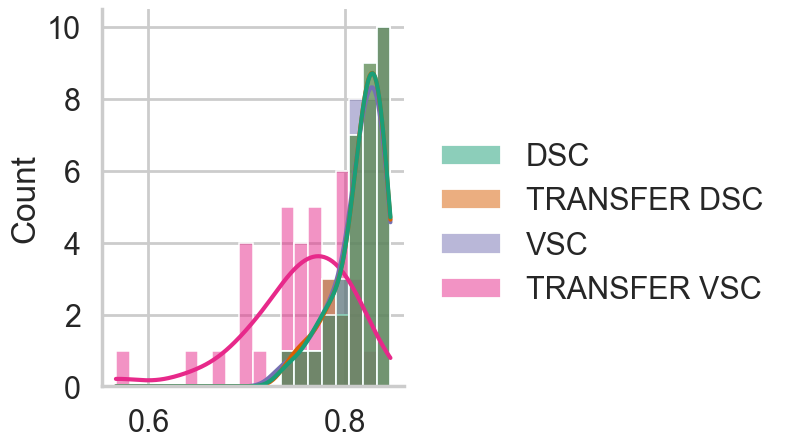

In [39]:
def overall_accs_report(weeks_to_train):
    mix_res_list = []
    transfer_res_list = []
    mmd_res_list = []
    for week in range(weeks_to_train - 1):
        mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[1])
        transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[1])
        #mmd_res_list.append(dd_acc_cat(y_apps_test_mmd[week], test[week])[1])
    

    vsc_res_list = []
    tvsc_res_list = []
    for week in range(weeks_to_train - 1):
        #if week != 7: #nan for some reason
        vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[1])
        tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[1])

    average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      #'MMD DSC': mmd_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
    plt.savefig(fname='Distribution of Accuracies.png')

    return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3), average_df


dsc, tdsc, vsc, tvsc, av_df = overall_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
#print('average DD accuracy on weeks for MMD DSC', mmd_dsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)


def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat(y_apps_test[week], test[week])[2])
    transfer_res_list.append(dd_acc_cat(y_apps_test_tdsc[week], test[week])[2])
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat(y_apps_test_vsc[week], test[week])[2])
    tvsc_res_list.append(dd_acc_cat(y_apps_test_tvsc[week], test[week])[2])

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        '#TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )
    plt.figure(figsize=(15,16))
    sns.displot(average_df, kde=True, bins=20)
    #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks for {}'.format(cat))
    plt.savefig(fname='Distribution of Accuracies for {}.png'.format(cat))

  return round(np.mean([item[cat] for item in mix_res_list]), 3), round(np.mean([item[cat] for item in transfer_res_list]), 3), round(np.mean([item[cat] for item in vsc_res_list]), 3), round(np.mean([item[cat] for item in tvsc_res_list]), 3)




average DD accuracy on weeks for Mix DSC 0.816
average DD accuracy on weeks for Transfer DSC 0.816
average DD accuracy on weeks for Mix VSC 0.815
average DD accuracy on weeks for Transfer VSC 0.787


<Figure size 1500x1600 with 0 Axes>

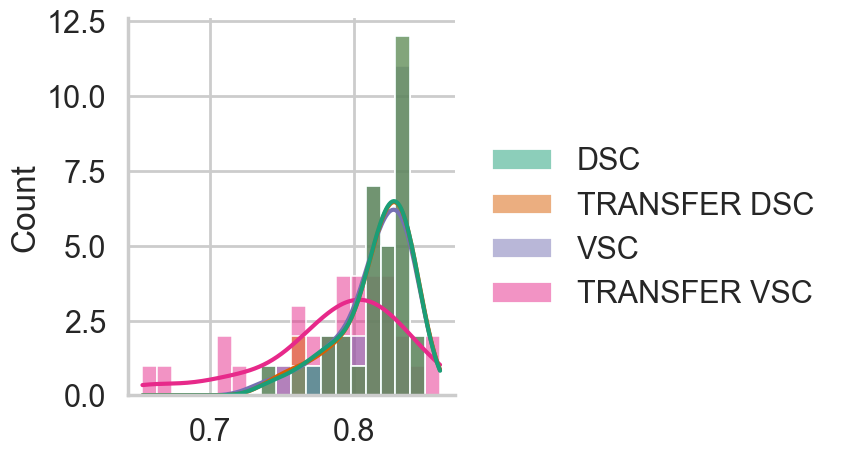

In [37]:
def overall_non_zero_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_cat_non_zero(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_cat_non_zero(y_apps_test_tdsc[week], test[week]))
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_cat_non_zero(y_apps_test_tvsc[week], test[week]))

  average_df = pd.DataFrame(
      {'DSC': mix_res_list,
      'TRANSFER DSC': transfer_res_list,
      'VSC': vsc_res_list,# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
      'TRANSFER VSC': tvsc_res_list,# + [np.mean(tvsc_res_list)],
      }
      )
  plt.figure(figsize=(15,16))
  sns.displot(average_df, kde=True, bins=20)
  #plt.title('Average DD accuracy for DSC, TrDSC, VSC, TrVSC on all training weeks')
  plt.savefig(fname='Distribution of Accuracies.png')

  return round(np.mean(mix_res_list), 3), round(np.mean(transfer_res_list), 3), round(np.mean(vsc_res_list), 3), round(np.mean(tvsc_res_list), 3)

dsc, tdsc, vsc, tvsc = overall_non_zero_accs_report(weeks_to_train)
  

print('average DD accuracy on weeks for Mix DSC', dsc)
print('average DD accuracy on weeks for Transfer DSC', tdsc)
print('average DD accuracy on weeks for Mix VSC', vsc)
print('average DD accuracy on weeks for Transfer VSC', tvsc)



In [ ]:
from sklearn.metrics import mean_squared_error

def dd_acc_cat(y_apps, data, target_only=False):
  s = 0
  acc_dict = dict()
  for cat_ind, cat in enumerate(appliance_categories):
    y_app = y_apps[cat][:,0,:]
    if target_only:
      y_real = data['X'][cat].iloc[:,target_ind:].values
    else:
      y_real = data['X'][cat].values
    s += np.sum(np.abs(y_real - y_app), axis=0)
    acc_dict[cat] = np.sum(np.abs(y_real - y_app), axis=0)

  if target_only:
    den = 2*data['X_bar'].iloc[:,target_ind:].sum(axis=0).values
  else: 
    den = 2*data['X_bar'].sum(axis=0).values
  return np.round(1 - s/den, 3), np.round(np.mean(1 - s/den), 3), {cat: 1 - v/den for cat,v in acc_dict.items()}


week = 0
def dd_acc_per_category(y_apps, data, target_only=False):
    s = 0
    error_dict = dict()
    for cat_ind, cat in enumerate(appliance_categories):
        y_app = y_apps[cat][:,0,:]
        if target_only:
            y_real = data['X'][cat].iloc[:,target_ind:].values
        else:
            y_real = data['X'][cat].values
        s += np.sum(np.abs(y_real - y_app), axis=0)
        error_dict[cat] = np.sqrt(mean_squared_error(y_real, y_app)), np.sqrt(mean_squared_error(y_real, y_app))/np.linalg.norm(y_real, 2)
        
    return error_dict

In [ ]:
def per_cat_accs_report(weeks_to_train):
  mix_res_list = []
  transfer_res_list = []
  for week in range(weeks_to_train - 1):
    mix_res_list.append(dd_acc_per_category(y_apps_test[week], test[week]))
    transfer_res_list.append(dd_acc_per_category(y_apps_test_tdsc[week], test[week]))
    

  vsc_res_list = []
  tvsc_res_list = []
  for week in range(weeks_to_train - 1):
    #if week != 7: #nan for some reason
    vsc_res_list.append(dd_acc_per_category(y_apps_test_vsc[week], test[week]))
    tvsc_res_list.append(dd_acc_per_category(y_apps_test_tvsc[week], test[week]))

  for cat_ind, cat in enumerate(appliance_categories):
    average_df = pd.DataFrame(
        {'DSC': [item[cat] for item in mix_res_list],
        'TRANSFER DSC': [item[cat] for item in transfer_res_list],
        'VSC': [item[cat] for item in vsc_res_list],# + [np.mean(vsc_res_list)], #the original week 7 was nan, need to fix
        'TRANSFER VSC': [item[cat] for item in tvsc_res_list],# + [np.mean(tvsc_res_list)],
        }
        )

  for cat in appliance_categories:
      errors_mix = [d[cat][0] for d in mix_res_list]
      print('average DSC error for {} is {}'.format(cat, np.round(np.mean(errors_mix))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in mix_res_list]), 3)))
      errors_source = [d[cat][0] for d in transfer_res_list]
      print('average T-DSC error for {} is {}'.format(cat, np.round(np.mean(errors_source))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in transfer_res_list]), 3)))
      errors_target = [d[cat][0] for d in vsc_res_list]
      print('average VSC error for {} is {}'.format(cat, np.round(np.mean(errors_target))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in vsc_res_list]), 3)))
      errors_tsc = [d[cat][0] for d in tvsc_res_list]
      print('average T-VSC error for {} is {}'.format(cat, np.round(np.mean(errors_tsc))), 'ratio is {}'.format(np.round(np.mean([d[cat][1] for d in tvsc_res_list]), 3)))
      print("\n")

    
  return errors_mix, errors_source, errors_target, errors_tsc


sc_cat, ssc_cat, tarsc_cat, tsc_cat = per_cat_accs_report(weeks_to_train)
  
